<a href="https://colab.research.google.com/github/vilsaira/example/blob/main/dMRI_signal_GP_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and/or upgrade packages

In [ ]:
!pip install dipy #Install dipy to colab environment
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install pyDOE
!pip install scipy --upgrade # Upgrade packages if needed, remember to restart kernel afterwards!

Get test data using dipy. Download takes about a minute. This example uses just b=1000 shell.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dipy.core.gradients import gradient_table
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.data import get_sphere, get_fnames

# Example from https://www.dipy.org/documentation/1.3.0./examples_built/reconst_mcsd/
sphere = get_sphere('symmetric724')

fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')

data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

bvals = gtab.bvals
bvecs = gtab.bvecs

#sel_b = np.logical_or(np.logical_or(bvals == 0, bvals == 1000), bvals == 2000)
sel_b = np.logical_or(bvals == 0, bvals == 1000)
data = data[..., sel_b]

gtab = gradient_table(bvals[sel_b], bvecs[sel_b])
bvals = gtab.bvals
bvecs = gtab.gradients

Gaussian Process needs the angular distances between b-vectors.

In [ ]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from pyDOE import lhs
from scipy.linalg import cholesky, det, solve


def _unit_vector(vector):
    return vector / np.linalg.norm(vector)

def _angle_between(v1, v2):
    v1_u = _unit_vector(v1)
    v2_u = _unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angles(vecs):
    n = vecs.shape[0]
    C = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            # Select smallest of two arccos|<g1,g2>| and arccos|<g1,-g2>|
            C[i,j] = np.min((
                _angle_between(vecs[i,:], vecs[j,:]), # g1, g2
                 _angle_between(vecs[i,:], -vecs[j,:]))) #g1, -g2

    C += C.T
    C = np.nan_to_num(C)
    return C

Covariance matrix or kernel based on a spherical model (Eq. 10) for one shell case

In [ ]:
def kernel_ss(lmbda, a, theta):
    # Single shell kernel
    # Exponential model (Eq. 9)
    # K = lmbda * np.exp(-theta/a)
    # Spherical model (Eq. 10)
    K = lmbda * (theta <= a) * (1 - 3*theta/(2*a) + theta**3 / (2* a**3))
    return K

Log marginal likelihood function which returns the negative value for scipy minimization.

In [ ]:
def likelihood(params, theta, y):

    lmbda = params[0]**2 #Ensure positive lambda
    a = params[1]
    sigmasq = params[2]**2  #Ensure positive sigmasq 
    n = y.shape[0]

    Ky = kernel_ss(lmbda, a, theta) + sigmasq * np.eye(theta.shape[0]) + 1e-10 * np.eye(n)
    # The last term of Ky (+1e10..) helps to avoid numerical problems in cholesky
    L = cholesky(Ky, lower=True)
    #Ky_inv = np.linalg.inv(Ky)

    # |Ky| = np.det(Ky)
    LnDetKy = np.sum( np.log( np.abs( np.diagonal(L)))) # This equals to 0.5*np.log(np.linalg.det(Ky))

    # over all voxels
    # vector version
    alphas = solve(L.T, solve(L, y))
    likes = -0.5 * y.T @ alphas - LnDetKy    
    # trace is the sum over all voxels
    like = np.trace(likes)
    # loop version - much slower
    # like = 0
    #for i in range(y.shape[1]):
    #    alpha = solve(L.T, solve(L, y[:,i]))
    #    like += (-0.5 * y[:,i].T @ alpha - LnDetKy).flatten()
    #    #y1 = np.atleast_2d(y[:,i]).T
    #    #alpha = cho_solve((L.T,True), cho_solve((L, True), y1))
    #    #like += (-0.5 * y1.T @ Ky_inv @ y1 - 0.5*np.log(np.linalg.det(Ky))).flatten()

    # Return negative value to maximize likelihood with scipy minimization
    return -like

GP prediction function

In [ ]:
def predict(params, theta, y):

    lmbda = params[0]
    a = params[1]
    sigmasq = params[2]

    n = y.shape[0]
    m = y.shape[1]
    one = np.ones((n,1)) 

    Ky = kernel_ss(lmbda, a, theta) + sigmasq * np.eye(n)
    k = kernel_ss(lmbda, a, theta)
    L = cholesky(Ky, lower=True)

    mu = np.zeros((m,))
    SigmaSqr = np.zeros((m,))
    pred = np.zeros((n,m))
    var = np.zeros((n,m))
    # iterate over all voxels
    for i in range(y.shape[1]):
        y1 = np.atleast_2d(y[:,i]).T
        #alpha = cho_solve((L.T, True), cho_solve((L, True), y1))
        alpha = solve(L.T, solve(L, y1))

        # Mean estimation
        mu[i] = (one.T @ (solve(L, y1))) / (one.T @ (solve(L, one)))

        # Variance estimation
        tmp = (y1 - mu[i]*one)
        SigmaSqr[i] = tmp.T @ (solve(L, tmp)) / n

        # Mean prediction
        pred[:, i] = (k.T @ alpha).flatten()

        # Variance prediction
        v = solve(L, k)
        var[:, i] = np.diag(k - v.T @ v)

    return pred, var

Get **theta** matrix [#ndwi, #ndwi] that contain angular distances and matrix **y** [#ndwi, #nvox] that contain DWI signals 

In [ ]:
N_vox = 1000 # number of voxels used in GP
np.random.seed(seed=42)

# theta matrix contains the angular distances between b-vecs [0, pi/2]
theta = angles(bvecs[~gtab.b0s_mask,:])

# apply rough brain masking
brain_mask = np.sum(data[:,:,:,1:], axis=3) > 3000
data1 = data * brain_mask[:,:,:,None]
data1 = data1.reshape(np.prod(brain_mask.shape), data1.shape[-1]).astype(np.float32)
idx = np.argwhere(data1[:,0] > 0)

# select N_vox random voxels within the brain mask
selection = np.random.choice(idx.flatten(), N_vox)

y = np.log(data1[selection,np.argwhere(~gtab.b0s_mask)])

Set number of iterations, bounds for the optimization, and get random initial parameters.

In [ ]:
n_repeats = 10
# bounds = [lambda, a, sigmasq]
bounds = np.array([[0, 1e5], [1e-10, np.pi/2], [0, 1e5]])
lhd = lhs(3, n_repeats)
initial_params = (bounds[:,1] - bounds[:,0]) * lhd + bounds[:,0]

Run minimization and find the best solution over all iterations.

In [ ]:
# This takes few seconds so results are also hardcoded to the next step
opt_para = np.zeros((n_repeats,3))
opt_fun = np.zeros((n_repeats,1))
for i in range(n_repeats):    
    res = minimize(likelihood, initial_params[i,:], args=(theta, y), method='Nelder-Mead', bounds=bounds)
    opt_para[i,:] = res.x
    opt_fun[i,:] = res.fun
    print(f"{i} : params = [{res.x}] : likelihood = {res.fun}")

params = opt_para[np.argmin(opt_fun)]
print(params)

0 : params = [[1.67528515 1.57079633 0.        ]] : likelihood = 19654.437185125113
1 : params = [[0.         1.57079633 4.59216944]] : likelihood = 66803.79604472898
2 : params = [[1.67523068 1.57079633 0.        ]] : likelihood = 19654.43719146619
3 : params = [[1.67523322 1.57079633 0.        ]] : likelihood = 19654.43718961837
4 : params = [[0.         0.06802026 4.59217005]] : likelihood = 66803.7960446861
5 : params = [[0.         0.34991524 4.59221901]] : likelihood = 66803.79604508406
6 : params = [[0.         0.61627446 4.59216939]] : likelihood = 66803.79604473192
7 : params = [[1.67529353 1.57079633 0.        ]] : likelihood = 19654.437190347366
8 : params = [[0.         1.57079633 4.59216549]] : likelihood = 66803.79604503154
9 : params = [[0.         0.0909095  4.59222837]] : likelihood = 66803.7960460147
[1.67528515 1.57079633 0.        ]


Get another random brain voxel and use the GP model to predict its signal.

4.6151104473205536e-15


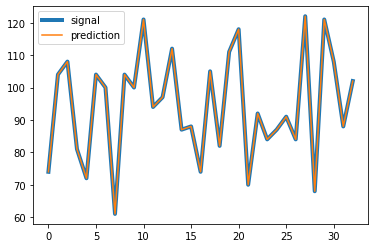

In [ ]:
params = np.array([1.67528515, 1.57079633, 0.])
while True:
  selection2 = np.random.choice(idx.flatten(), 1)
  if np.sum(selection2 == selection) == 0:
    break # test data is not part of training data

y1 = np.log(data1[selection2,np.argwhere(~gtab.b0s_mask)])
pred, var = predict(params, theta, y1)

plt.plot(np.exp(y1), label='signal', linewidth=4)
plt.plot(np.exp(pred), label='prediction')
plt.legend()
print(np.sqrt(np.sum( (y1 - pred)**2)))

Adding outliers highlight the failed optimization: model with these parameters is clearly not robust towards outliers.

6.217248937900877e-15


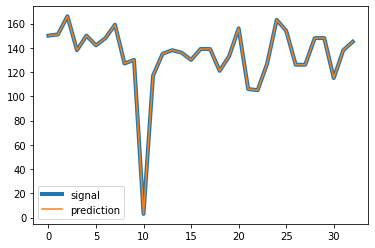

In [ ]:
while True:
  selection2 = np.random.choice(idx.flatten(), 1)
  if np.sum(selection2 == selection) == 0:
    break # test data is not part of training data

y1 = np.log(data1[selection2,np.argwhere(~gtab.b0s_mask)])
# OUTLIER
y1[10] = 1.1
pred, var = predict(params, theta, y1)

plt.plot(np.exp(y1), label='signal', linewidth=4)
plt.plot(np.exp(pred), label='prediction')
plt.legend()
print(np.sqrt(np.sum( (y1 - pred)**2)))